In [1]:
import json, io
import numpy as np
import torch
import torch.nn as nn


from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
EPOCH_SIZE = 65536
BATCH_SIZE = 4096
VAL_SIZE = 524288

LONG_INTERVAL = 200
SHORT_INTERVAL = 10

learning_rate = 0.0003
l2r = 0
checkpoint = -1
save = True
model_name = "new_parrot"

In [3]:
class SimpleModel(nn.Module):

    def __init__(self, name):
        super().__init__()

        self.name = name

        self.conv_net = nn.Sequential()
        self.conv_net.add_module("Conv 1", nn.Conv2d(1, 100, 2, 1))
        self.conv_net.add_module("Batchnorm 1", nn.BatchNorm2d(100))
        self.conv_net.add_module("Conv activation", nn.LeakyReLU())
        self.conv_net.add_module("Conv 2", nn.Conv2d(100, 250, 2, 1))
        self.conv_net.add_module("Batchnorm 2", nn.BatchNorm2d(250))
        self.conv_net.add_module("Conv activation 2", nn.LeakyReLU())
        self.conv_net.add_module("Conv 3", nn.Conv2d(250, 400, 3, 1))
        self.conv_net.add_module("Batchnorm 3", nn.BatchNorm2d(400))
        self.conv_net.add_module("Conv activation 3", nn.LeakyReLU())
        self.conv_net.add_module("Conv 4", nn.Conv2d(400, 700, 4, 1))
        self.conv_net.add_module("Batchnorm 4", nn.BatchNorm2d(700))
        self.conv_net.add_module("Conv activation 4", nn.LeakyReLU())
        self.conv_net.add_module("Flattener", nn.Flatten())

        self.mlp = nn.Sequential()
        self.mlp.add_module("Layer 1", nn.Linear(712, 500))
        self.mlp.add_module("Activation 1", nn.LeakyReLU())
        self.mlp.add_module("Layer 2", nn.Linear(500, 250))
        self.mlp.add_module("Activation 2", nn.LeakyReLU())
        self.mlp.add_module("Layer 3", nn.Linear(250, 1))
        self.mlp.add_module("Activation 3", nn.Sigmoid())

    def forward(self, x, feat):
        x = self.conv_net.forward(x)
        y = torch.column_stack((x, feat))
        return self.mlp.forward(y)

class MeanModel(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, a, b):
        return torch.mean(a)


def read_data(dataset_name: str) -> (list, list, list):
    p = list(np.load(f"/content/drive/MyDrive/parrot/chessevaldata/{dataset_name}_pos.npy"))
    f = list(np.load(f"/content/drive/MyDrive/parrot/chessevaldata/{dataset_name}_feat.npy"))
    e = list(np.load(f"/content/drive/MyDrive/parrot/chessevaldata/{dataset_name}_eval.npy"))
    return (p, f, e)

In [4]:
validations = [123,246,369,492,615,738,861,984]

val_position_list, val_feature_list, val_eval_list = read_data(f"train_{validations[0] // 16}_{validations[0] % 16}")
print("Validation datasets:")
print(f"train_{validations[0] // 16}_{validations[0] % 16}")
for numb in validations[1:]:
  print(f"train_{numb // 16}_{numb % 16}")
  vp, vf, ve = read_data(f"train_{numb // 16}_{numb % 16}")
  val_position_list += vp
  val_feature_list += vf
  val_eval_list += ve

print(np.array(val_position_list).shape)
val_position_list = np.array(val_position_list)
val_feature_list = np.array(val_feature_list)
val_eval_list = np.array(val_eval_list)

Validation datasets:
train_7_11
train_15_6
train_23_1
train_30_12
train_38_7
train_46_2
train_53_13
train_61_8
(524288, 1, 8, 8)


In [ ]:
import time
import random
import os

# configuring device
try:
    device = xm.xla_device()
    print("Running on the TPU")
except:
    if torch.cuda.is_available():
        device = torch.device('cuda:0')
        print('Running on the GPU')
        torch.cuda.synchronize()
    else:
        device = torch.device('cpu')
        print('Running on the CPU')

model = SimpleModel(model_name).to(device=device)
loss_fn = nn.MSELoss()

if checkpoint == 0:
    model = SimpleModel(model_name).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    num_epoch = 0
    best_vloss = 1000
    model.train()
    with open(f"/content/drive/MyDrive/parrot/{model_name}_loss.csv", "w") as file:
        file.write("")
    print("Using new models.")
elif checkpoint == -1:
    model = SimpleModel(model_name)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    print("Loading from last checkpoint.")
    checkpoint_file = torch.load(f"/content/drive/MyDrive/parrot/{model_name}.pickle", weights_only=True)
    model.load_state_dict(checkpoint_file["model_state_dict"])
    model.to(device=device)
    optimizer.load_state_dict(checkpoint_file["optimizer_state_dict"])

    # Update learning rate in case it is changed midway.
    for g in optimizer.param_groups:
      g['lr'] = learning_rate

    num_epoch = checkpoint_file["epoch"] + 1
    best_vloss = checkpoint_file["best_loss"]
    model.train()
    print(f"Best validation loss at checkpoint: {best_vloss}")

else:
    model = SimpleModel(model_name)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    print(f"Loading from epoch {checkpoint}.")
    checkpoint_file = torch.load(f"/content/drive/MyDrive/parrot/{model_name}_{checkpoint}.pickle", weights_only=True)
    model.load_state_dict(checkpoint_file["model_state_dict"])
    model.to(device=device)
    optimizer.load_state_dict(checkpoint_file["optimizer_state_dict"])

    # Update learning rate in case it is changed midway.
    for g in optimizer.param_groups:
      g['lr'] = learning_rate

    num_epoch = checkpoint_file["epoch"] + 1
    best_vloss = checkpoint_file["best_loss"]
    model.train()
    print(f"Best validation loss at checkpoint: {best_vloss}")



print(model)
print("Batch size = ", BATCH_SIZE)
print("Validation size = ", VAL_SIZE)
print("L2 regularisation strength = ", l2r)
print("Learning rate = ", learning_rate)

tlr, tl, vl = [], [], []

running_mean = 0
M2 = 0
readings = 0

for epoch in range(num_epoch, 2000000):
    rd = random.randint(0, 1351)
    while (rd in validations):
        rd = random.randint(0, 1351)
    print(f"Epoch {epoch} - Training on dataset {rd // 16}_{rd % 16}.")
    start = time.time()
    while True:
        try:
            bl, fl, el = read_data(f"train_{rd // 16}_{rd % 16}")
            break
        except:
            pass
    zipped = list(zip(bl, fl, el))
    random.shuffle(zipped)
    bl, fl, el = zip(*zipped)
    cl = 0
    clr = 0
    data_load_time = time.time() - start
    readings += 1
    delta = data_load_time - running_mean
    running_mean += delta / readings
    delta2 = data_load_time - running_mean
    M2 += (delta * delta2)
    variance = M2 / readings
    print(f"Data loaded in {data_load_time} seconds. Mean {running_mean}, Stdev {variance ** 0.5}")
    if (len(bl) != EPOCH_SIZE) or (len(fl) != EPOCH_SIZE) or (len(el) != EPOCH_SIZE):
        print(f"Dataset train_{rd // 16}_{rd % 16} is invalid.")
        continue
    else:
        start = time.time()
        for batch in range(EPOCH_SIZE // BATCH_SIZE):
            tb = torch.tensor(np.array(bl[batch * BATCH_SIZE : (batch + 1) * BATCH_SIZE]), device=device, dtype=torch.float).reshape(BATCH_SIZE, 1, 8, 8)
            tf = torch.tensor(np.array(fl[batch * BATCH_SIZE : (batch + 1) * BATCH_SIZE]), device=device, dtype=torch.float).reshape(BATCH_SIZE, 12)
            te = torch.tensor(np.array(el[batch * BATCH_SIZE : (batch + 1) * BATCH_SIZE]), device=device, dtype=torch.float).reshape(BATCH_SIZE, 1)

            optimizer.zero_grad()
            out = model.forward(tb, tf)
            loss = loss_fn(out, te)
            l = loss.item()
            cl += l
            if l2r != 0:
                l2 = sum(p.pow(2).sum() for p in model.parameters())
                loss += l2 * l2r
                llr = loss.item()
                clr += llr
            loss.backward()
            optimizer.step()
            tl.append(l)
            if l2r != 0:
                tlr.append(llr)
            completion = int(20 * batch / (EPOCH_SIZE // BATCH_SIZE)) + 1
            if l2r != 0:
                print("\r" + f"[{'-' * completion} {' ' * (20 - completion)}]     Loss {round(l, 6)}, Regularised loss {round(llr, 6)}", end = "")
            else:
                print("\r" + f"[{'-' * completion} {' ' * (20 - completion)}]     Loss {round(l, 6)}", end = "")
        if l2r != 0: print(f"\nEpoch {epoch}, loss {round(cl / (EPOCH_SIZE // BATCH_SIZE), 6)}, regularised loss {round(clr / (EPOCH_SIZE // BATCH_SIZE), 6)}, completed in {time.time() - start} seconds.")
        else: print(f"\nEpoch {epoch}, loss {round(cl / (EPOCH_SIZE // BATCH_SIZE), 6)}, completed in {time.time() - start} seconds.")

        with torch.no_grad():
            tvl = 0
            start = time.time()
            for vbatch in range(VAL_SIZE // BATCH_SIZE):
                vp = torch.tensor(val_position_list[vbatch * BATCH_SIZE : (vbatch + 1) * BATCH_SIZE], device=device, dtype=torch.float).reshape(BATCH_SIZE, 1, 8, 8)
                vf = torch.tensor(val_feature_list[vbatch * BATCH_SIZE : (vbatch + 1) * BATCH_SIZE], device=device, dtype=torch.float).reshape(BATCH_SIZE, 12)
                ve = torch.tensor(val_eval_list[vbatch * BATCH_SIZE : (vbatch + 1) * BATCH_SIZE], device=device, dtype=torch.float).reshape(BATCH_SIZE, 1)
                out = model.forward(vp, vf)
                loss = loss_fn(out, ve)
                tvl += loss.item()

            print("Validation loss", round(tvl / (VAL_SIZE // BATCH_SIZE), 6), "completed in", time.time() - start, "seconds.")
            vl.append(tvl / (VAL_SIZE // BATCH_SIZE))
            if (tvl / (VAL_SIZE // BATCH_SIZE)) < best_vloss:
                print("New best model!")
                best_vloss = tvl / (VAL_SIZE // BATCH_SIZE)
                torch.save(model.state_dict(), f"/content/drive/MyDrive/parrot/best_{model_name}.pickle")

        if save:
            if epoch % LONG_INTERVAL == 0:
                torch.save({"epoch": epoch, "model_state_dict": model.state_dict(), "optimizer_state_dict": optimizer.state_dict(), "best_loss": best_vloss}, f"/content/drive/MyDrive/parrot/{model_name}_{epoch}.pickle")
            if epoch % SHORT_INTERVAL == 0:
                torch.save({"epoch": epoch, "model_state_dict": model.state_dict(), "optimizer_state_dict": optimizer.state_dict(), "best_loss": best_vloss}, f"/content/drive/MyDrive/parrot/{model_name}.pickle")
            try:
                os.remove(f"/content/drive/MyDrive/parrot/{model_name}_{epoch - LONG_INTERVAL}.pickle")
            except:
                pass

        with open(f"/content/drive/MyDrive/parrot/{model_name}_loss.csv", "a") as file:
            file.write(f"{epoch}, {round(cl / (EPOCH_SIZE // BATCH_SIZE), 6)}, {round(tvl / (VAL_SIZE // BATCH_SIZE), 6)}\n")


Running on the GPU
Loading from last checkpoint.
Best validation loss at checkpoint: 0.018321362615097314
SimpleModel(
  (conv_net): Sequential(
    (Conv 1): Conv2d(1, 100, kernel_size=(2, 2), stride=(1, 1))
    (Batchnorm 1): BatchNorm2d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (Conv activation): LeakyReLU(negative_slope=0.01)
    (Conv 2): Conv2d(100, 250, kernel_size=(2, 2), stride=(1, 1))
    (Batchnorm 2): BatchNorm2d(250, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (Conv activation 2): LeakyReLU(negative_slope=0.01)
    (Conv 3): Conv2d(250, 400, kernel_size=(3, 3), stride=(1, 1))
    (Batchnorm 3): BatchNorm2d(400, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (Conv activation 3): LeakyReLU(negative_slope=0.01)
    (Conv 4): Conv2d(400, 700, kernel_size=(4, 4), stride=(1, 1))
    (Batchnorm 4): BatchNorm2d(700, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (Conv activation 4): Le

In [ ]:
loss_fn_2 = nn.L1Loss()
print(val_position_list[0])
print(val_eval_list[0])
mm = MeanModel()
with torch.no_grad():
    model.eval()
    mm.eval()
    tvl = 0
    cl2 = 0
    tvl2 = 0
    cl3 = 0
    for vbatch in range(VAL_SIZE // BATCH_SIZE):
        vp = torch.tensor(val_position_list[vbatch * BATCH_SIZE : (vbatch + 1) * BATCH_SIZE], device=device, dtype=torch.float).reshape(BATCH_SIZE, 1, 8, 8)
        vf = torch.tensor(val_feature_list[vbatch * BATCH_SIZE : (vbatch + 1) * BATCH_SIZE], device=device, dtype=torch.float).reshape(BATCH_SIZE, 12)
        ve = torch.tensor(val_eval_list[vbatch * BATCH_SIZE : (vbatch + 1) * BATCH_SIZE], device=device, dtype=torch.float).reshape(BATCH_SIZE, 1)
        out = model.forward(vp, vf)
        loss = loss_fn(out, ve)
        loss2 = loss_fn_2(out, ve)
        tvl += loss.item()
        cl2 += loss2.item()
        out2 = mm.forward(vp, vf)
        loss22 = loss_fn(out2, ve)
        loss222 = loss_fn_2(out2, ve)
        tvl2 += loss22.item()
        cl3 += loss222.item()

    print("Validation loss", round(tvl / (VAL_SIZE // BATCH_SIZE), 6))
    print(f"L1 {cl2 / (VAL_SIZE // BATCH_SIZE)}")
    print("Bench loss", round(tvl2 / (VAL_SIZE // BATCH_SIZE), 6))
    print("Bench L1", round(cl3 / (VAL_SIZE // BATCH_SIZE), 6))

[[[0.8333 0.5    0.5    0.9167 1.     0.75   0.5    0.8333]
  [0.5833 0.5833 0.5833 0.6667 0.5833 0.5    0.5833 0.5833]
  [0.5    0.5    0.5    0.5    0.5    0.6667 0.5    0.5   ]
  [0.5    0.5    0.5    0.5833 0.5    0.5    0.25   0.5   ]
  [0.5    0.5    0.5    0.5    0.5    0.5    0.75   0.5   ]
  [0.5    0.5    0.5    0.25   0.5    0.3333 0.5    0.5   ]
  [0.4167 0.4167 0.4167 0.5    0.5    0.4167 0.4167 0.4167]
  [0.1667 0.3333 0.5    0.0833 0.5    0.1667 0.     0.5   ]]]
0.4977500187498125


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([4096, 1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:128: UserWarning: Using a target size (torch.Size([4096, 1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


Validation loss 0.018556
L1 0.08697600301820785
Bench loss 0.068896
Bench L1 0.194736


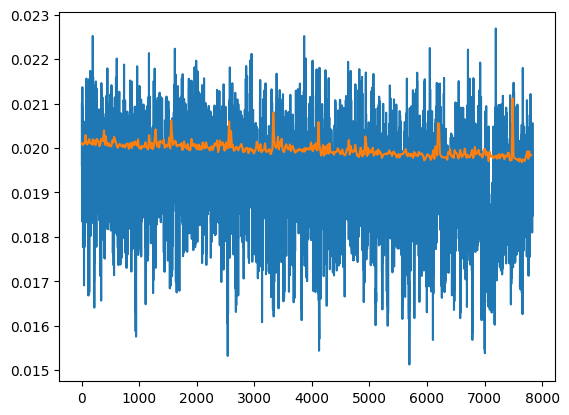

Bench loss 0.06675350666046143


<ipython-input-7-f3399f4d4032>:21: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  tb = torch.tensor(bl[b * 8192 : (b + 1) * 8192], device=device, dtype=torch.float).reshape(8192, 1, 8, 8)


Model loss 0.01706142583861947


FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/parrot/chessevaldata/validation_pos.npy'

In [ ]:
import matplotlib.pyplot as plt

plt.plot(np.arange(len(tl)), tl)
plt.plot(np.arange(0, len(vl)*(EPOCH_SIZE // BATCH_SIZE), (EPOCH_SIZE // BATCH_SIZE)), vl)
plt.show()
rd = random.randint(0, 243)
bl, fl, el = read_data(f"train_{rd // 4}_{rd % 4}")

m = np.mean(el)
cl=0
for batch in range(16):
    te = torch.tensor(el[batch * 4096 : (batch + 1) * 4096], device=device, dtype=torch.float).reshape(4096, 1)
    loss = loss_fn(torch.ones(4096, device=device, dtype=torch.float).reshape(4096, 1) * m, te)
    cl += loss.item()
print(f"Bench loss {cl / 16}")

with torch.no_grad():
    cl = 0
    model.eval()
    for b in range(8):
        tb = torch.tensor(bl[b * 8192 : (b + 1) * 8192], device=device, dtype=torch.float).reshape(8192, 1, 8, 8)
        tf = torch.tensor(fl[b * 8192 : (b + 1) * 8192], device=device, dtype=torch.float).reshape(8192, 12)
        te = torch.tensor(el[b * 8192 : (b + 1) * 8192], device=device, dtype=torch.float).reshape(8192, 1)

        out = model.forward(tb, tf)
        loss = loss_fn(out, te)
        cl += loss.item()
    print(f"Model loss {cl / 8}")


vpl, vfl, vel = read_data("validation")
vp = torch.tensor(val_position_list, device=device, dtype=torch.float).reshape(32768, 1, 8, 8)
vf = torch.tensor(val_feature_list, device=device, dtype=torch.float).reshape(32768, 12)
ve = torch.tensor(val_eval_list, device=device, dtype=torch.float).reshape(32768, 1)

with torch.no_grad():
    model.eval()
    out = model.forward(vp, vf)
    loss = loss_fn(out, ve)

    print("Validation loss", loss.item())
    loss = loss_fn(torch.ones(32768, device=device, dtype=torch.float).reshape(32768, 1) * np.mean(ve.squeeze(-1).cpu().numpy()), ve)
    print(f"Bench val loss", loss.item())

test_position_list = vpl[:32]
test_feature_list = vfl[:32]
test_eval_list = vel[:32]

ttp = torch.tensor(test_position_list, device=device, dtype=torch.float).reshape(32, 1, 8, 8)
ttf = torch.tensor(test_feature_list, device=device, dtype=torch.float).reshape(32, 12)
tte = torch.tensor(test_eval_list, device=device, dtype=torch.float).reshape(32, 1)

with torch.no_grad():
    model.eval()
    out = model.forward(ttp, ttf)
    print(out)
    loss = loss_fn(out, tte)
    print("Test loss", loss.item())

In [ ]:
!pip install chess
import chess
import re

chr_to_num = {"k": 0, "q": 1, "r": 2, "b": 3, "n": 4, "p": 5, "P": 7, "N": 8, "B": 9, "R": 10, "Q": 11, "K": 12}

def square_to_int(sq):
    return (ord(sq[0]) - 97) * 8 + int(sq[1]) - 1

def squareint_to_square(sqint):
    return (sqint // 8, sqint % 8)

def int_to_bin(anint, pad=4):
    return [int(_) for _ in "0" * (pad - len(bin(anint)[2:])) + bin(anint)[2:]]

def board_to_boardlist(board):
    boards = [[[0 for _ in range(8)] for _ in range(8)] for _ in range(12)]
    for square, piece in board.piece_map().items():
        idx = squareint_to_square(square)
        boards[chr_to_num[piece.symbol()]][idx[0]][idx[1]] = 1
    return boards

def board_to_boardmap(board):
    boards = [[0.5 for _ in range(8)] for _ in range(8)]
    for square, piece in board.piece_map().items():
        idx = squareint_to_square(square)
        boards[idx[0]][idx[1]] = round((chr_to_num[piece.symbol()]) / 12, 4)
    return [boards]


def fen_to_feature_wboard_list(fen_str):
    board = re.split(" |/", fen_str)
    r = 0
    whosemove = []
    enpassqnum = board[10]
    can_enpassant = [0]
    castling_rights = [0, 0, 0, 0]
    if enpassqnum != "-":
        enpassqnum = int_to_bin(square_to_int(enpassqnum), pad=6)
        can_enpassant = [1]
    else:
        enpassqnum = int_to_bin(0, pad=6)
    for entry in board:
        if entry == "w":
            whosemove = [1]edit
        elif r == 9:
            if entry.find("K") != -1:
                castling_rights[0] = 1
            if entry.find("Q") != -1:
                castling_rights[1] = 1
            if entry.find("k") != -1:
                castling_rights[2] = 1
            if entry.find("q") != -1:
                castling_rights[3] = 1
        r += 1
    return whosemove + can_enpassant + enpassqnum + castling_rights




In [ ]:
board = chess.Board("rnbqknbr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR w - - 0 1")
print(board)
b1 = torch.tensor(board_to_boardmap(board), device=device, dtype=torch.float).reshape(1, 1, 8, 8)
print(b1)
f1 = torch.tensor(fen_to_feature_wboard_list(board.fen()), device=device, dtype=torch.float).reshape(1, 12)

with torch.no_grad():
    model.eval()
    print(model.forward(b1, f1))

r n b q k n b r
p p p p p p p p
. . . . . . . .
. . . . . . . .
. . . . . . . .
. . . . . . . .
P P P P P P P P
R N B Q K B N R
tensor([[[[0.8333, 0.6667, 0.7500, 0.9167, 1.0000, 0.7500, 0.6667, 0.8333],
          [0.5833, 0.5833, 0.5833, 0.5833, 0.5833, 0.5833, 0.5833, 0.5833],
          [0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000],
          [0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000],
          [0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000],
          [0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000],
          [0.4167, 0.4167, 0.4167, 0.4167, 0.4167, 0.4167, 0.4167, 0.4167],
          [0.1667, 0.3333, 0.2500, 0.0833, 0.0000, 0.3333, 0.2500, 0.1667]]]],
       device='cuda:0')
tensor([[0.5209]], device='cuda:0')
